In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import gdown
file_id = '1eTtRs5cUlBP5dXsx-FTAlmXuB6JQi2qj'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

gdown.download(url, output='file.zip', quiet=False)

In [ ]:
import zipfile
zip_file_path = 'file.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_folder')

import os
os.listdir('extracted_folder')

In [ ]:
!mv extracted_folder/PUBHEALTH pubhealth
!rm -rf /content/extracted_folder
!rm -rf /content/file.zip

In [2]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import regex as re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
!pip install sentence-transformers

In [3]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
stop_words = set(stopwords.words('english'))

In [4]:
stop_words = set(stopwords.words('english'))
file_paths = {
        "train": "train.tsv",
        "test": "test.tsv"
    }

def read_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    df = df[['claim', 'main_text', 'label']]
    df.dropna(axis=0, inplace=True)

    def preprocess_text(text):
        text = re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.lower()
        return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

    df['main_text'] = df['main_text'].apply(preprocess_text)
    df['claim'] = df['claim'].apply(preprocess_text)

    df = df[df['label'].str.contains('snopes') == False]
    label_dict = {'true': 0, 'false': 1, 'mixture': 2, 'unproven': 3}
    df['label'] = df['label'].map(label_dict)
    return df

In [5]:
file_paths = {
        "train": "train.tsv",
        "test": "test.tsv"
    }

In [ ]:
file_paths = {
        "train": "pubhealth/train.tsv",
        "test": "pubhealth/test.tsv",
        "valid": "pubhealth/dev.tsv"
    }

In [ ]:
def read_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    df = df[['claim', 'main_text', 'label']]
    df.dropna(axis=0, inplace=True)

    def preprocess_text(text):
        text = re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.lower()
        return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

    df['main_text'] = df['main_text'].apply(preprocess_text)
    df['claim'] = df['claim'].apply(preprocess_text)

    df = df[df['label'].str.contains('snopes') == False]
    label_dict = {'true': 0, 'false': 1, 'mixture': 2, 'unproven': 3}
    df['label'] = df['label'].map(label_dict)
    return df

In [ ]:
def retrieve_top_k_sentences(claim, main_text, k=3, model=None):

    sentences = nltk.sent_tokenize(main_text)
    if model is None:
        raise ValueError("A SentenceTransformer model must be provided")
    claim_embedding = model.encode(claim, convert_to_tensor=True)
    sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
    similarities = util.cos_sim(claim_embedding, sentence_embeddings)[0]
    top_k_indices = similarities.argsort(descending=True)[:k]
    return ' '.join([sentences[i] for i in top_k_indices])

In [6]:
def load_and_preprocess_data(file_paths):
    datasets = {}
    for key, path in file_paths.items():
        df = read_data(path)
        #df['top_k_sentences'] = df.apply(
        #    lambda row: retrieve_top_k_sentences(row['claim'], row['main_text'], model=sbert_model), axis=1

        datasets[key] = df
    return datasets

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
sbert_model = SentenceTransformer('all-mpnet-base-v2')
datasets = load_and_preprocess_data(file_paths)

In [ ]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')

In [9]:
datasets = load_and_preprocess_data(file_paths)

In [10]:
def tokenize_data(data, tokenizer):
    return tokenizer(
        data["claim"].tolist(),
        data["main_text"].tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

In [11]:
class PUBHEALTHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        # Store encodings and labels as tensors
        labels = [int(label) if isinstance(label, float) else int(label) for label in labels]
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.encodings = encodings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Use clone().detach() instead of torch.tensor() for existing tensors
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx].clone().detach()
        return item


In [ ]:
class PUBHEALTHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):

        labels = [int(label) if isinstance(label, float) else int(label) for label in labels]
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.encodings = encodings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [ ]:
torch.cuda.empty_cache()

In [25]:
def evaluate_model(true_labels, predicted_labels, label_mapping):
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    true_labels_str = [reverse_mapping[label] for label in true_labels]
    predicted_labels_str = [reverse_mapping[label] for label in predicted_labels]

    print("Classification Report:\n", classification_report(true_labels_str, predicted_labels_str))
    cm = confusion_matrix(true_labels_str, predicted_labels_str, labels=list(label_mapping.keys()))
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model_performance(trainer, test_dataset, test_labels, label_mapping):
    predictions = trainer.predict(test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=1)
    evaluate_model(test_labels, predicted_labels, label_mapping)

In [ ]:
def evaluate_model_performance(trainer, test_dataset, test_labels, label_mapping):
    predictions = trainer.predict(test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=1)
    evaluate_model(test_labels, predicted_labels, label_mapping)

In [19]:
from sklearn.utils.class_weight import compute_class_weight
# Calculate class weights based on training labels
def calculate_class_weights(dataset):
    labels = dataset['label'].values
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels
    )
    return torch.tensor(class_weights, dtype=torch.float)

In [20]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)  # Move weights to GPU/CPU

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)  # Use weighted loss
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss



In [ ]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)  # Move weights to GPU/CPU

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)  # Use weighted loss
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [21]:

def train_model_with_weights(train_dataset, model):
    # Calculate class weights
    class_weights = calculate_class_weights(datasets["train"])  # Using the train dataset

    # Define training arguments
    training_args = TrainingArguments(eval_strategy="no",
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        num_train_epochs=4,
        weight_decay=0.05,
        logging_dir="./logs",
        logging_steps=100,
        save_strategy="epoch",
    )

    # Initialize the custom weighted trainer
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        class_weights=class_weights
    )

    trainer.train()
    return trainer


In [12]:
def train_model(train_dataset, model):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        #per_device_eval_batch_size=32,
        num_train_epochs=4,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        #eval_dataset=valid_dataset,
    )
    trainer.train()
    return trainer

In [13]:
def train_model(train_dataset, model):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.05,
        logging_dir="./logs",
        logging_steps=100
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset
    )
    trainer.train()
    return trainer

In [22]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
def prepare_datasets(datasets, tokenizer):
    tokenized_datasets = {}

    for key, df in datasets.items():
        df = df.dropna(subset=["label"])

        encodings = tokenize_data(df, tokenizer)
        tokenized_datasets[key] = PUBHEALTHDataset(encodings, df["label"].tolist())

    return tokenized_datasets

In [16]:
label_map = {
    'true': 0,
    'false': 1,
    'mixture': 2,
    'unproven': 3
}

tokenized_datasets = prepare_datasets(datasets, tokenizer)

In [17]:
tokenized_datasets

{'train': <__main__.PUBHEALTHDataset at 0x7aaabd3ec1f0>,
 'test': <__main__.PUBHEALTHDataset at 0x7aaabd44ea10>}

In [ ]:
trainer = train_model(
        tokenized_datasets["train"],
        model
    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-9-800bde727a44>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
100,0.877700
200,0.772300
300,0.714100
400,0.645200
500,0.613100
600,0.597600
700,0.504800
800,0.505200
900,0.479300


<ipython-input-9-800bde727a44>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
torch.save(trainer.model.state_dict(), 'scibert_model1.pth')


<ipython-input-9-800bde727a44>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Classification Report:
               precision    recall  f1-score   support

       false       0.62      0.85      0.72       388
     mixture       0.50      0.32      0.39       201
        true       0.87      0.80      0.83       599
    unproven       0.41      0.20      0.27        45

    accuracy                           0.72      1233
   macro avg       0.60      0.54      0.55      1233
weighted avg       0.72      0.72      0.70      1233



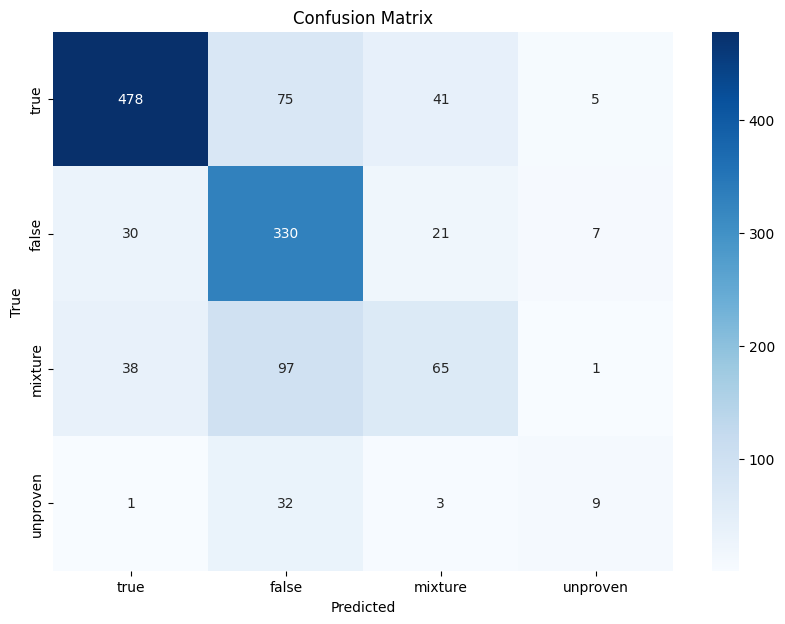

In [ ]:
evaluate_model_performance(
        trainer,
        tokenized_datasets["test"],
        datasets["test"]["label"].tolist(),
        {'true': 0, 'false': 1, 'mixture': 2, 'unproven': 3}
    )

In [23]:
trainer2 = train_model_with_weights(
        tokenized_datasets["train"],
        model
    )

Step,Training Loss
100,1.209000
200,1.038900
300,0.981200
400,0.882700
500,0.815700
600,0.794300
700,0.671700
800,0.669500
900,0.652000
1000,0.542100


In [24]:
torch.save(trainer2.model.state_dict(), 'scibert_model2.pth')

Classification Report:
               precision    recall  f1-score   support

       false       0.68      0.68      0.68       388
     mixture       0.33      0.53      0.40       201
        true       0.93      0.71      0.81       599
    unproven       0.36      0.47      0.40        45

    accuracy                           0.66      1233
   macro avg       0.57      0.60      0.57      1233
weighted avg       0.73      0.66      0.69      1233



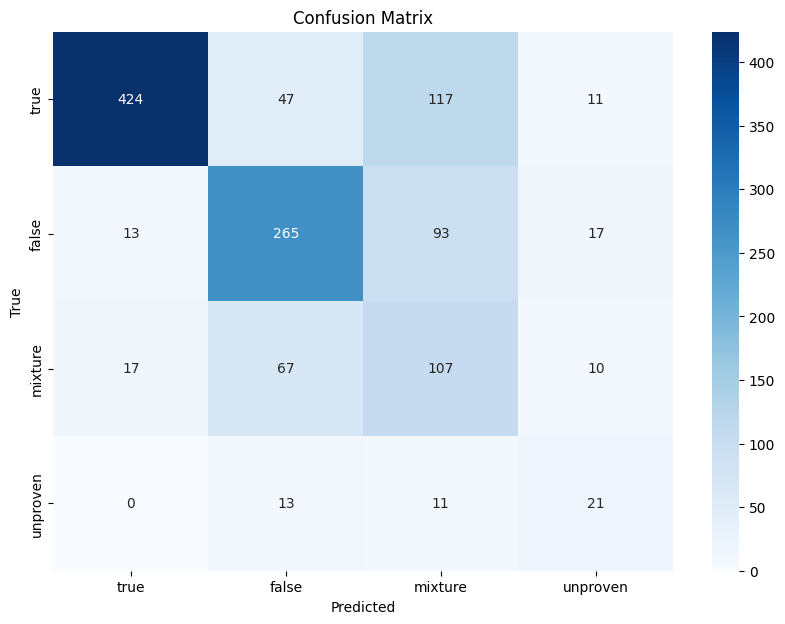

In [26]:
evaluate_model_performance(
        trainer2,
        tokenized_datasets["test"],
        datasets["test"]["label"].tolist(),
        {'true': 0, 'false': 1, 'mixture': 2, 'unproven': 3}
    )